In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecg-data/CWT.py
/kaggle/input/ecg-data/check_preproc_df
/kaggle/input/ecg-data/VECG.py


In [2]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import TensorDataset
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import sys
import os

In [4]:
# Подгружаем пути к директориям с нашими алгоритмами:
cur_dir = os.getcwd()
wavelets_path = os.path.join(cur_dir, "../input/ecg-data/")
script_path = os.path.join(cur_dir, "../input/ecg-data/")
print(script_path)
print(wavelets_path)
sys.path.append(wavelets_path)
sys.path.append(script_path)

/kaggle/working/../input/ecg-data/
/kaggle/working/../input/ecg-data/


In [5]:
# Подгружаем алгоритмы для подготовки данных:
import VECG as vecg # Алгоритмы для формирования векторного представления кардиоциклов
import CWT as wt # Алгоритмы для вейвлет преобразования графиков ЭКГ

In [6]:
data_size = 1000

In [7]:
ECG_df = pd.read_pickle('/kaggle/input/ecg-data/check_preproc_df')

In [8]:
ECG_df = ECG_df[0:2*data_size]

In [9]:
vecg.init(filtering=True, canc_showing=True, plot3D=False, enable_centering = True, enable_local_normalize=True)
ECG_df = vecg.make_vecg_df(ECG_df, 0, 2)
ECG_df.head()

Я в процессе
Я кончил


,data,label,XY,YZ,ZX
855,"[[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.024, 0...",AF,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1523,"[[-0.015, -0.015, -0.015, -0.015, -0.015, -0.0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
80,"[[0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0....",AF,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
593,"[[-0.195, -0.195, -0.195, -0.195, -0.195, -0.1...",AF,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1145,"[[-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [10]:
def binarize(X):
    for i, row in X.iterrows():
        X.at[i, "XY"][X.at[i, "XY"] == 255] = 0
        X.at[i, "XY"][X.at[i, "XY"] != 0] = 1
        
        X.at[i, "YZ"][X.at[i, "YZ"] == 255] = 0
        X.at[i, "YZ"][X.at[i, "YZ"] != 0] = 1
        
        X.at[i, "ZX"][X.at[i, "ZX"] == 255] = 0
        X.at[i, "ZX"][X.at[i, "ZX"] != 0] = 1
            

In [11]:
import gc
def transform(X):
    #for i in range(X.shape[1]):
    X[0][:] = X[0][:] - 0.485
    X[1][:] = X[1][:] - 0.456
    X[2][:] = X[2][:] - 0.406
        
    X[0][:] = X[0][:] / 0.229
    X[1][:] = X[1][:] / 0.224
    X[2][:] = X[2][:] / 0.225
    gc.collect()
    return X

In [12]:
binarize(ECG_df)

In [13]:
#transform(ECG_df)
gc.collect()

12732000

In [14]:
# Формируем непосредственно набор данных и меток:
X_ECG = np.array([ECG_df.iloc[:,2].tolist(),
                 ECG_df.iloc[:,3].tolist(),
                 ECG_df.iloc[:,4].tolist()])
X_ECG = X_ECG.astype("float32")
X_ECG = transform(X_ECG)
X_ECG = np.transpose(X_ECG, (1, 2, 3, 0))
#X_ECG[X_ECG == 255 ] = 0
#X_ECG[X_ECG != 0] = 1
y_ECG = np.array(ECG_df.iloc[:,1].tolist())

In [15]:
# Производим деление выборки на тренировочную и тестовую
X_train, X_test = (X_ECG[:int(data_size *10/11)*2], X_ECG[int(data_size *10/11)*2:data_size*2])
y_train, y_test = (y_ECG[:int(data_size *10/11)*2], y_ECG[int(data_size *10/11)*2:data_size*2])

X_ECG = 0
y_ECG = 0
gc.collect()

X_val, y_val = X_train[:int(data_size * 1/10) * 2], y_train[:int(data_size * 1/10) * 2]
X_train, y_train = X_train[int(data_size * 1/10) * 2:], y_train[int(data_size * 1/10) * 2:]



In [16]:
X_train = np.transpose(X_train, (0, 3, 1, 2 ))
X_test = np.transpose(X_test, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))

In [17]:
# Нормируем данные
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_val = X_val.astype('float32')
# X_train = X_train / 255.0 * 0.99 + 0.01
# X_test = X_test / 255.0 * 0.99 + 0.01

In [18]:
y_train = np.array([1 if label == "SR" else 0 for label in y_train])
y_test = np.array([1 if label == "SR" else 0 for label in y_test])
y_val = np.array([1 if label == "SR" else 0 for label in y_val])

In [19]:
# # Производим энкодинг полученных меток классов в удобный для обработки сетью вид
# print('Метка класса перед энкодингом:', y_train[:10])
# encoder = OneHotEncoder()
# encoder.fit(y_train.reshape(-1, 1))
# y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
# y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
# y_val = encoder.transform(y_val.reshape(-1, 1)).toarray()
# print('Метка класса после энкодинга:', y_train[:10])
# encoder.categories_

In [20]:
print(y_train.shape)

(1618,)


In [21]:
gc.collect()

0

In [22]:
# Создание Dataset и DataLoader
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

In [23]:
X_train = 0
X_test = 0
X_val = 0

gc.collect()

0

In [24]:
batch_size = 15

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True)

In [25]:
#googlenet = torchvision.models.googlenet(pretrained=True)
resnet18 = torchvision.models.resnet18(pretrained=True)
model = resnet18

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
import gc
gc.collect()

21

In [28]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super(InceptionBlock, self).__init__()
        # 1x1 convolution
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 convolution followed by 3x3 convolution
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 convolution followed by 5x5 convolution
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(self.inception3a(x))
        x = self.maxpool4(self.inception4e(self.inception4d(self.inception4c(self.inception4b(self.inception4a(x))))))
        x = self.inception5b(self.inception5a(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [29]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'mean') -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction


    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss


In [30]:
#googlenet = GoogLeNet(num_classes = 2)
#Changing the last fc to 4 output features
#GoogLeNet.fc = torch.nn.Linear(in_features=512, out_features=4)
# Заменяем последний fully connected слой для задачи классификации
num_classes = 2  # Замените на количество классов в вашей задаче
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

criterion = torch.nn.CrossEntropyLoss()
#criterion = FocalLoss()

#optimizer = torch.optim.ASGD(googlenet.parameters(), lr=3e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#optimizer = optim.LBFGS(model.parameters(), lr=0.01)

In [31]:
def validate(model, dataloader, criterion, device):
    model.eval()  # Переводим модель в режим оценки (без обновления весов)

    correct = 0
    total = 0

    with torch.no_grad():
        for val_step, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    model.train()  # Возвращаем модель в режим обучения

In [32]:
def train(model, epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  # Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        model.train() # set model to training phase
        model.to(device)
        
        for train_step, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Once we get the loss we need to take a gradient step
            loss.backward() # Back propagation
            optimizer.step() # Completes the gradient step by updating all the parameter values (we are using all parameters)
            train_loss += loss.item() # Loss is a tensor which can't be added to train_loss so .item() converts it to float
               

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
        validate(model, val_dataloader, criterion, device)
    print('Training complete..')

In [33]:
%%time

train(model=model, epochs=50)

Starting training..
Starting epoch 1/50
Training Loss: 0.6290
Validation Accuracy: 69.00%
Starting epoch 2/50
Training Loss: 0.4687
Validation Accuracy: 69.00%
Starting epoch 3/50
Training Loss: 0.4013
Validation Accuracy: 67.00%
Starting epoch 4/50
Training Loss: 0.3717
Validation Accuracy: 73.00%
Starting epoch 5/50
Training Loss: 0.3075
Validation Accuracy: 76.00%
Starting epoch 6/50
Training Loss: 0.2486
Validation Accuracy: 65.00%
Starting epoch 7/50
Training Loss: 0.2341
Validation Accuracy: 73.00%
Starting epoch 8/50
Training Loss: 0.1557
Validation Accuracy: 70.00%
Starting epoch 9/50
Training Loss: 0.1467
Validation Accuracy: 62.50%
Starting epoch 10/50
Training Loss: 0.1300
Validation Accuracy: 76.00%
Starting epoch 11/50
Training Loss: 0.1189
Validation Accuracy: 78.00%
Starting epoch 12/50
Training Loss: 0.0867
Validation Accuracy: 74.50%
Starting epoch 13/50
Training Loss: 0.0803
Validation Accuracy: 76.00%
Starting epoch 14/50
Training Loss: 0.0436
Validation Accuracy: 74

In [34]:
def test(model, dataloader, criterion, device):
    model.eval()  # Переводим модель в режим оценки (без обновления весов)

    correct = 0
    total = 0
    y_pred = []

    with torch.no_grad():
        for val_step, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    model.train()  # Возвращаем модель в режим обучения
    return y_pred

In [35]:
y_pred_test = test(model, test_dataloader, criterion, device)

Test Accuracy: 79.12%



 clasification report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        97
           1       0.84      0.68      0.75        85

    accuracy                           0.79       182
   macro avg       0.80      0.78      0.79       182
weighted avg       0.80      0.79      0.79       182

Матрица несоответствий для тестовой выборки:



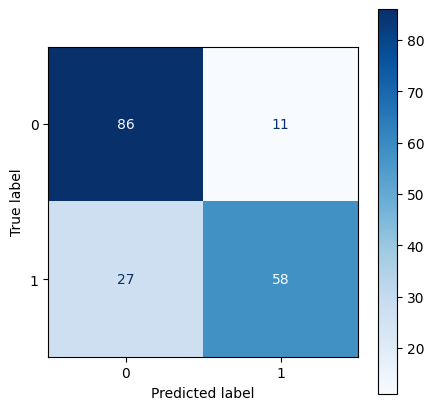

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print ('\n clasification report:\n', classification_report(y_test, y_pred_test))

print('Матрица несоответствий для тестовой выборки:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
disp.plot(cmap = 'Blues', ax=ax);

In [38]:
torch.save(model.state_dict(), 'resnet18.pt')